# Final Project


### Our goal is to replicate the results in the paper: Quantifying Fiscal Multipliers in New Zealand: the Evidence from SVAR Models, by Anna Hamer-Adams and Martin Wong (2018)

#### We start by importing the packages and functions that we will need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from pandas_datareader.data import DataReader 
from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
%matplotlib inline

#### Now, we import the data. We have the original data used by the authors in an excel file, and we will use pandas to create a dataframe

In [2]:
df = pd.read_excel('Data Project.xlsx', index_col=0, parse_dates=True)

In [3]:
df

,G,NT,Y,DP,I
DATE,,,,,
1990-07-01,-0.725721,0.098405,2.075329,0.009991,0.142879
1990-10-01,-0.852352,0.103060,2.091817,0.010791,0.138444
1991-01-01,-0.743720,0.075223,2.054770,0.006228,0.120922
1991-04-01,-0.887704,0.027803,2.042473,0.000884,0.104248
1991-07-01,-1.149231,-0.049311,2.049949,0.003534,0.093297
...,...,...,...,...,...
2016-10-01,-0.088609,0.963686,2.522910,0.004136,0.020846
2017-01-01,-0.151277,0.975417,2.519845,0.009885,0.019930
2017-04-01,-0.068217,1.001268,2.530826,0.000000,0.019663


## Let's take a look at the data

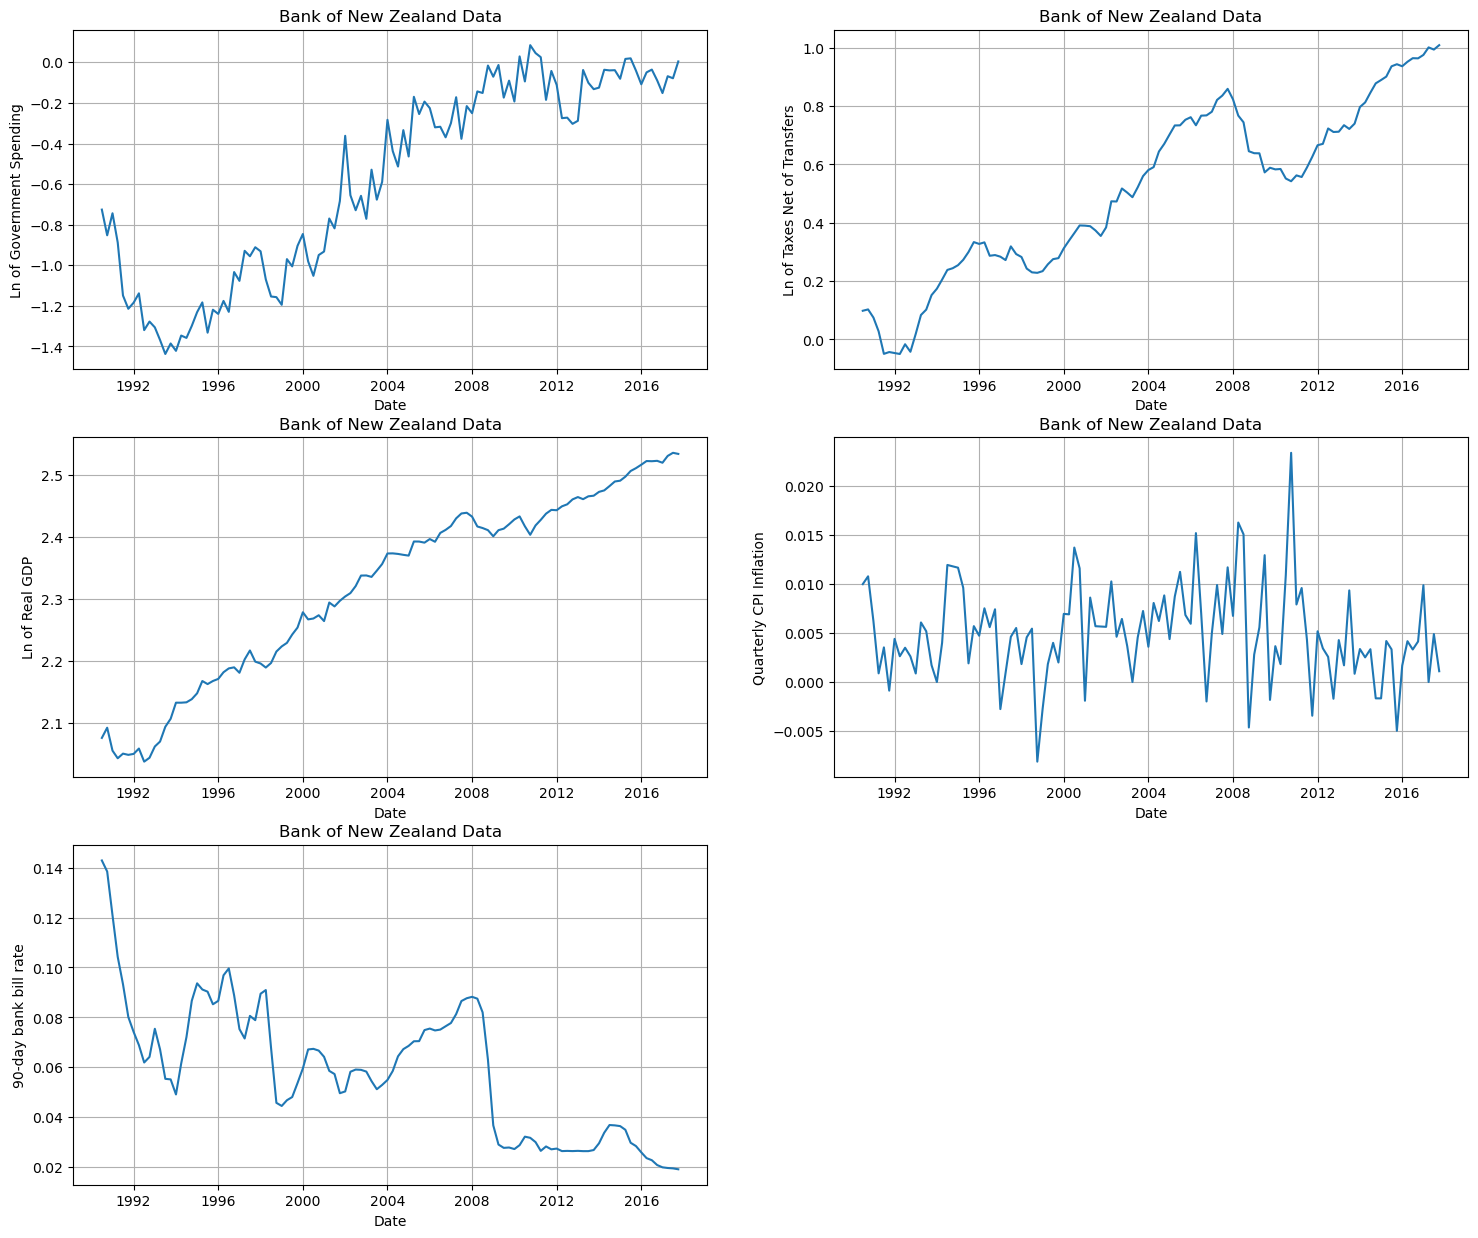

In [4]:
plt.figure(figsize=(18,15))
plt.subplot(321)
plt.plot(df["G"])
plt.xlabel('Date')
plt.ylabel('Ln of Government Spending')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(322)
plt.plot(df["NT"])
plt.xlabel('Date')
plt.ylabel('Ln of Taxes Net of Transfers')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(323)
plt.plot(df["Y"])
plt.xlabel('Date')
plt.ylabel('Ln of Real GDP')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(324)
plt.plot(df["DP"])
plt.xlabel('Date')
plt.ylabel('Quarterly CPI Inflation')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(325)
plt.plot(df["I"])
plt.xlabel('Date')
plt.ylabel('90-day bank bill rate')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.show()

## We have the data, now we need to define a class, so that it can estimate the parameters of the model with our data, identify the structural shocks and create impulse response functions.




In [5]:
class SVAR_Model1():
    def __init__(self, X, lags=3, num_impulses = 10):  
        self.X = X                                    
        self.lags = lags                 # In the paper, they define the model with 3 lags and 10 periods for the impulse response horizons.
        self.num_impulses = num_impulses # So we set these values as default, but create the attributes in case we want to test different specifications
        
    def Xlags(self):  # We need to create a dataframe with lags of our variables to use as dependent variables in the VAR model.
        XLAG = pd.DataFrame()
        for l in range(1,self.lags+1):
            XLAG = pd.concat([XLAG, self.X.shift(l).add_suffix("-"+str(l))], axis=1)
        X_avlb_dta = X.iloc[self.lags:,:]
        XLAG_avlb_dta = XLAG.iloc[self.lags:,:]  # Now we need to exclude from X and XLAG the observations where we have no data available for the lags.
        Xa = np.array(X_avlb_dta)                # And transform them in arrays so later we can perform math/algebra operations with them
        XLAGa = np.array(XLAG_avlb_dta)
        return Xa, XLAGa
    
    def ols_fit(self):   # Here, we use ols to estimate our VAR (reduced form) and recover the coefficients and rediduals
        Xa, XLAGa = self.Xlags()
        Bhat = inv(XLAGa.T@XLAGa)@XLAGa.T@Xa
        ϵ = (Xa-XLAGa@Bhat)
        return Bhat, ϵ
        